# Capstone Project - The battle of Neighborhoods

## Introduction: Business Problem

One of the critical aspects for the success of a restaurant in a city like Barcelona is where to place it. Specifically, this project aims to predict whether an new Italian restaurant in Barcelona should be placed in order to have more probabilities to success.
Obviously, any person trying to start a business like that or any person or company interested on investing on this kind of business would be interested on that.


## Data

For the purpose of this project we will choose to open the restaurant in the neighborhood that accomplishes that:
- Pertains to the Cluster where more Italian restaurant are placed, as for some reason is the place where this kind of restaurant succeeds the most
- From that Cluster we'll choose the neighhborhood with the lowest density of Italian Restaurants by Population

To get that we will use 3 sources of information:
- Density population by Neighborhoods. This is open data from Barcelona government that can be found here: https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-densitat/resource/08c88565-5b50-47d1-8234-6d3dd2da4c58
- Geopy to get the coordinates of each Neighborhood
- Foursquare to find the venues close to each Neighborhood

*Before we get the data and start exploring it, let's download all the dependencies that we will need.*

In [1]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes 

#import libraries
import pandas as pd
import numpy as np
import folium # map rendering library
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

## 1. Explore Barcelona dataset

In [2]:
BCN_density=pd.read_csv('2019_densitat.csv')
BCN_density.head()

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Població,Superfície (ha),Superfície Residencial (ha),Densitat (hab/ha),Densitat neta (hab/ha)
0,2019,1,Ciutat Vella,1,el Raval,47353,110.0,49.6,430,955
1,2019,1,Ciutat Vella,2,el Barri Gòtic,18629,81.6,34.1,228,546
2,2019,1,Ciutat Vella,3,la Barceloneta,14857,109.5,13.5,136,1097
3,2019,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",22590,111.0,32.4,204,697
4,2019,2,Eixample,5,el Fort Pienc,32349,92.9,33.6,348,962


In [3]:
#Rename columns to English
BCN_density.columns = ['Year','District_Code','District','Neighborhood_Code','Neighborhood','Population','Area (ha)','Residential Area (ha)','Density','Net Density']
#Drop Year as is latest data from 2019, District Code & Neighborhood Code,Residential Area
BCN_density.drop(['Year','District_Code','Neighborhood_Code','Residential Area (ha)','Net Density'],axis=1, inplace=True)

Let's find some highlights about the city of Barcelona

In [4]:
#Let's explore a bit about the city of Barcelona
print('Total population of Barcelona is: ' + str(BCN_density['Population'].sum()))
print('Total Area of Barcelona is: ' + str(BCN_density['Area (ha)'].sum()))
print('Density of Barcelona city is: ' +str(BCN_density['Population'].sum() / BCN_density['Area (ha)'].sum()) )
print('Total number of Neighborhoods are: ' +str(BCN_density['Neighborhood'].count()))
print('Total number of Districts are: ' + str(BCN_density['District'].nunique()))

Total population of Barcelona is: 1636762
Total Area of Barcelona is: 10135.7
Density of Barcelona city is: 161.48485057766112
Total number of Neighborhoods are: 73
Total number of Districts are: 10


Lets explore which are the most and least populated and most and least dense neighborhoods in the city of Barcelona

In [5]:
#These are the 5 most populated Neighborhoods in Barcelona
BCN_density.sort_values(['Population'],ascending=False).head()

,District,Neighborhood,Population,Area (ha),Density
8,Eixample,la Nova Esquerra de l'Eixample,58032,134.1,433
59,Sant Andreu,Sant Andreu,57843,186.7,310
5,Eixample,la Sagrada Família,51385,104.2,493
30,Gràcia,la Vila de Gràcia,50102,132.1,379
25,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,47588,166.9,285


In [6]:
#These are the 5 most dense Neighborhoods in Barcelona
BCN_density.sort_values(['Density'],ascending=False).head()

,District,Neighborhood,Population,Area (ha),Density
16,Sants-Montjuïc,Sants - Badal,24312,41.5,586
31,Gràcia,el Camp d'en Grassot i Gràcia Nova,34911,65.1,537
50,Nou Barris,Verdun,12531,23.7,528
62,Sant Andreu,Navas,22176,42.4,523
63,Sant Martí,el Camp de l'Arpa del Clot,38663,74.1,522


In [7]:
#These are the 5 least populated Neighborhoods in Barcelona
BCN_density.sort_values(['Population'],ascending=True).head()

,District,Neighborhood,Population,Area (ha),Density
41,Horta-Guinardó,la Clota,683,17.8,38
11,Sants-Montjuïc,la Marina del Prat Vermell,1196,1403.4,1
55,Nou Barris,Vallbona,1405,60.8,23
46,Nou Barris,Can Peguera,2288,11.9,193
57,Sant Andreu,Baró de Viver,2597,23.0,113


In [8]:
#These are the 5 least dense Neighborhoods in Barcelona
BCN_density.sort_values(['Density'],ascending=True).head()

,District,Neighborhood,Population,Area (ha),Density
11,Sants-Montjuïc,la Marina del Prat Vermell,1196,1403.4,1
21,Sarrià-Sant Gervasi,"Vallvidrera, el Tibidabo i les Planes",4698,1132.9,4
53,Nou Barris,Torre Baró,2914,174.2,17
55,Nou Barris,Vallbona,1405,60.8,23
39,Horta-Guinardó,Montbau,5109,205.5,25


## 2. Find coordinates of each Neighborhood with Geopy

In [9]:
#Now we'll look for coordinates of each neighborhood 
#first we'll rework a bit the name of the neighborhoods so we can find it using geopy
BCN_density.replace(to_replace='Vallvidrera, el Tibidabo i les Planes',value='Vallvidrera',inplace=True)

latitude_list=[]
longitude_list=[]
neighborhood_list=[]

for address, district in zip(BCN_density['Neighborhood'],BCN_density['District']):
    address2 = address + ', ' + district + ', Barcelona'
    if address == district:
        address2 = address + ', Barcelona'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address2)
    latitude = location.latitude
    longitude = location.longitude
    latitude_list.append(latitude)
    longitude_list.append(longitude)    


In [10]:
#Now we add latitude & longitude to the dataframe
BCN_density['latitude']=latitude_list 
BCN_density['longitude']=longitude_list
BCN_density.head()

,District,Neighborhood,Population,Area (ha),Density,latitude,longitude
0,Ciutat Vella,el Raval,47353,110.0,430,41.379518,2.168368
1,Ciutat Vella,el Barri Gòtic,18629,81.6,228,41.383395,2.176912
2,Ciutat Vella,la Barceloneta,14857,109.5,136,41.380653,2.189927
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",22590,111.0,204,41.372251,2.177532
4,Eixample,el Fort Pienc,32349,92.9,348,41.395925,2.182325


Let's now visualize the different Neighborhoods in the map of the city

In [11]:
#Find coordinates for Barcelona to center next map of neighborhoods
address = 'Barcelona'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Barcelona are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Barcelona are 41.3828939, 2.1774322.


In [12]:
# create map of Barcelona city using latitude and longitude values
map_BCN = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(BCN_density['latitude'], BCN_density['longitude'], BCN_density['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BCN)  
    
map_BCN

## 3. Use Foursquare API to get venues of each Neighborhood

In [13]:
#Client ID and Secret ID for Foursquare API
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [14]:
#Let's define a function to get the venues for each coordinate in a radius of 1 km
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#Let's find the venues
limit=100
BCN_venues = getNearbyVenues(names=BCN_density['Neighborhood'],
                                   latitudes=BCN_density['latitude'],
                                   longitudes=BCN_density['longitude']
                                  )
BCN_venues = BCN_venues[BCN_venues['Venue Category'] != 'Neighborhood']

el Raval
el Barri Gòtic
la Barceloneta
Sant Pere, Santa Caterina i la Ribera
el Fort Pienc
la Sagrada Família
la Dreta de l'Eixample
l'Antiga Esquerra de l'Eixample
la Nova Esquerra de l'Eixample
Sant Antoni
el Poble Sec
la Marina del Prat Vermell
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants - Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera
Sarrià
les Tres Torres
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
el Putxet i el Farró
Vallcarca i els Penitents
el Coll
la Salut
la Vila de Gràcia
el Camp d'en Grassot i Gràcia Nova
el Baix Guinardó
Can Baró
el Guinardó
la Font d'en Fargues
el Carmel
la Teixonera
Sant Genís dels Agudells
Montbau
la Vall d'Hebron
la Clota
Horta
Vilapicina i la Torre Llobeta
Porta
el Turó de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baró
Ciutat Meridiana
Vallbona
la Trinitat Vella
Baró de Viver
el Bon Pastor
Sant Andreu
la Sagrera
el Congrés i els Indians

In [17]:
#Let's find how many venues we've found
print(BCN_venues.shape)
BCN_venues.head()

(5851, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,el Raval,41.379518,2.168368,La Robadora,41.379500,2.170463,Gastropub
1,el Raval,41.379518,2.168368,Las Fernández,41.378183,2.166354,Mediterranean Restaurant
2,el Raval,41.379518,2.168368,Chulapio,41.379264,2.165905,Cocktail Bar
3,el Raval,41.379518,2.168368,Robadors 23,41.379581,2.170603,Jazz Club
4,el Raval,41.379518,2.168368,Cera 23,41.378947,2.166180,Spanish Restaurant


In [18]:
#Number of venues by Neighborhood
BCN_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Baró de Viver,99,99,99,99,99,99
Can Baró,100,100,100,100,100,100
Can Peguera,100,100,100,100,100,100
Canyelles,22,22,22,22,22,22
Ciutat Meridiana,10,10,10,10,10,10
...,...,...,...,...,...,...
la Vila Olímpica del Poblenou,48,48,48,48,48,48
la Vila de Gràcia,100,100,100,100,100,100
les Corts,100,100,100,100,100,100


In [19]:
print('There are {} uniques categories.'.format(len(BCN_venues['Venue Category'].unique())))

There are 288 uniques categories.


**As we've found a long list of different categories we are going to extract them in en CSV and create an aggregation of those**

So for example, we'll group Italian Restaurant and Pizza Place or Spanish Restaurant and Tapas Restaurant or also Gym and Fitness Center


In [20]:
#let's find all different Venue Categories
BCN_venues['Venue Category'].value_counts().to_frame().to_csv("BCN_Venues_Category.csv")

In [21]:
#Let's import csv file with categories grouped
Group_Categories=pd.read_csv('Group_Categories.csv',delimiter=';')
Group_Categories.head()

,Venue_Category,Grouped_Category
0,Spanish Restaurant,Spanish restaurants
1,Tapas Restaurant,Spanish restaurants
2,Restaurant,Spanish restaurants
3,Hotel,Hotels and accomodations
4,Mediterranean Restaurant,Spanish restaurants


In [22]:
#Rename columns
Group_Categories.columns= ['Venue Category','Grouped Category']
Group_Categories.head()

,Venue Category,Grouped Category
0,Spanish Restaurant,Spanish restaurants
1,Tapas Restaurant,Spanish restaurants
2,Restaurant,Spanish restaurants
3,Hotel,Hotels and accomodations
4,Mediterranean Restaurant,Spanish restaurants


In [23]:
#Let's replace Café By Cafe as it gives issues
BCN_venues.replace(to_replace='Café',value='Cafe',inplace=True)

In [24]:
#Let's add GRouped Category in dataframe
BCN_venues=BCN_venues.join(Group_Categories.set_index('Venue Category'), on='Venue Category', how='left')

In [25]:
#Let's drop Venue Category attribute
BCN_venues.drop(['Venue Category'],axis=1,inplace=True)

In [26]:
#Let's rename Grouped Category to Venue Category
BCN_venues.columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue','Venue Latitude','Venue Longitude','Venue Category']
BCN_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,el Raval,41.379518,2.168368,La Robadora,41.379500,2.170463,Bars and pubs
1,el Raval,41.379518,2.168368,Las Fernández,41.378183,2.166354,Spanish restaurants
2,el Raval,41.379518,2.168368,Chulapio,41.379264,2.165905,Bars and pubs
3,el Raval,41.379518,2.168368,Robadors 23,41.379581,2.170603,Bars and pubs
4,el Raval,41.379518,2.168368,Cera 23,41.378947,2.166180,Spanish restaurants


In [27]:
#Let's find now number of unique venue categories now
BCN_venues['Venue Category'].nunique()

26

In [28]:
# one hot encoding
BCN_onehot = pd.get_dummies(BCN_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BCN_onehot.insert(0,'Neighborhood',BCN_venues['Neighborhood'],True)

BCN_onehot.head()

,Neighborhood,African restaurants,American restaurants,Arts and entertainment,Asian restaurants,Bakeries and coffee places,Bars and pubs,Beauty Services,Education Places,European restaurants,...,Markets and food stores,Medical center,Middle Eastern restaurants,Non-classified places,Non-food stores,Offices and services,Other international restaurants,Pharmacy,Spanish restaurants,Stadiums and racetracks
0,el Raval,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,el Raval,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,el Raval,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,el Raval,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
#Group by Neighborhood
BCN_sum = BCN_onehot.groupby('Neighborhood').sum().reset_index()
BCN_sum.head()

,Neighborhood,African restaurants,American restaurants,Arts and entertainment,Asian restaurants,Bakeries and coffee places,Bars and pubs,Beauty Services,Education Places,European restaurants,...,Markets and food stores,Medical center,Middle Eastern restaurants,Non-classified places,Non-food stores,Offices and services,Other international restaurants,Pharmacy,Spanish restaurants,Stadiums and racetracks
0,Baró de Viver,0,3,1,5,7,2,1,0,1,...,14,0,0,1,29,0,0,0,14,3
1,Can Baró,0,0,4,5,9,10,1,0,0,...,13,0,0,0,3,0,0,0,19,2
2,Can Peguera,0,1,2,3,8,7,0,0,1,...,22,0,0,0,0,0,0,0,24,1
3,Canyelles,0,0,0,0,3,0,0,0,0,...,5,0,0,0,0,0,0,0,2,3
4,Ciutat Meridiana,0,0,0,0,1,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0


In [30]:
#Add Italian Restaurants to BCN data. We'll be used later to check amount of Italian restaurants by Neighborhood and Cluster
BCN_data=BCN_density.join(BCN_sum[['Neighborhood','Italian restaurants']].set_index('Neighborhood'),on='Neighborhood',how='left')
BCN_data.head()

,District,Neighborhood,Population,Area (ha),Density,latitude,longitude,Italian restaurants
0,Ciutat Vella,el Raval,47353,110.0,430,41.379518,2.168368,3
1,Ciutat Vella,el Barri Gòtic,18629,81.6,228,41.383395,2.176912,6
2,Ciutat Vella,la Barceloneta,14857,109.5,136,41.380653,2.189927,3
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",22590,111.0,204,41.372251,2.177532,6
4,Eixample,el Fort Pienc,32349,92.9,348,41.395925,2.182325,4


In [31]:
BCN_mean = BCN_onehot.groupby('Neighborhood').mean().reset_index()
BCN_mean.head()

,Neighborhood,African restaurants,American restaurants,Arts and entertainment,Asian restaurants,Bakeries and coffee places,Bars and pubs,Beauty Services,Education Places,European restaurants,...,Markets and food stores,Medical center,Middle Eastern restaurants,Non-classified places,Non-food stores,Offices and services,Other international restaurants,Pharmacy,Spanish restaurants,Stadiums and racetracks
0,Baró de Viver,0.0,0.030303,0.010101,0.050505,0.070707,0.020202,0.010101,0.0,0.010101,...,0.141414,0.0,0.0,0.010101,0.292929,0.0,0.0,0.0,0.141414,0.030303
1,Can Baró,0.0,0.000000,0.040000,0.050000,0.090000,0.100000,0.010000,0.0,0.000000,...,0.130000,0.0,0.0,0.000000,0.030000,0.0,0.0,0.0,0.190000,0.020000
2,Can Peguera,0.0,0.010000,0.020000,0.030000,0.080000,0.070000,0.000000,0.0,0.010000,...,0.220000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.240000,0.010000
3,Canyelles,0.0,0.000000,0.000000,0.000000,0.136364,0.000000,0.000000,0.0,0.000000,...,0.227273,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.136364
4,Ciutat Meridiana,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.000000,...,0.200000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.100000,0.000000


Let's now find the top5 Venue categories for each Neighborhood

In [32]:
num_top_venues = 5

for hood in BCN_mean['Neighborhood']:
    print("----"+hood+"----")
    temp = BCN_mean[BCN_mean['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baró de Viver----
                        venue  freq
0             Non-food stores  0.29
1         Spanish restaurants  0.14
2     Markets and food stores  0.14
3       Fast food restaurants  0.08
4  Bakeries and coffee places  0.07


----Can Baró----
                        venue  freq
0         Spanish restaurants  0.19
1   Historic and public sites  0.17
2     Markets and food stores  0.13
3               Bars and pubs  0.10
4  Bakeries and coffee places  0.09


----Can Peguera----
                        venue  freq
0         Spanish restaurants  0.24
1     Markets and food stores  0.22
2   Historic and public sites  0.09
3  Bakeries and coffee places  0.08
4       Fast food restaurants  0.08


----Canyelles----
                        venue  freq
0   Historic and public sites  0.23
1     Markets and food stores  0.23
2     Stadiums and racetracks  0.14
3  Bakeries and coffee places  0.14
4         Spanish restaurants  0.09


----Ciutat Meridiana----
                        ve

## 4. Cluster Neighborhoods

First we are going to find which are the top 10 venues for each Neighborhood in order to perform the clustering

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BCN_mean['Neighborhood']

for ind in np.arange(BCN_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BCN_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baró de Viver,Non-food stores,Markets and food stores,Spanish restaurants,Fast food restaurants,Bakeries and coffee places,Asian restaurants,Historic and public sites,American restaurants,Stadiums and racetracks,Italian restaurants
1,Can Baró,Spanish restaurants,Historic and public sites,Markets and food stores,Bars and pubs,Bakeries and coffee places,Gym and sports centers,Asian restaurants,Arts and entertainment,Non-food stores,Fast food restaurants
2,Can Peguera,Spanish restaurants,Markets and food stores,Historic and public sites,Bakeries and coffee places,Fast food restaurants,Italian restaurants,Bars and pubs,Asian restaurants,Gym and sports centers,Arts and entertainment
3,Canyelles,Historic and public sites,Markets and food stores,Bakeries and coffee places,Stadiums and racetracks,Spanish restaurants,Gym and sports centers,Fast food restaurants,American restaurants,Arts and entertainment,Asian restaurants
4,Ciutat Meridiana,Historic and public sites,Markets and food stores,Bakeries and coffee places,Spanish restaurants,Healthy and Theme Restaurants,American restaurants,Arts and entertainment,Asian restaurants,Bars and pubs,Beauty Services


Now we are going to find the optimal number of Clusters based on the Elbow Method

In [35]:
BCN_grouped_clustering = BCN_mean.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(BCN_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

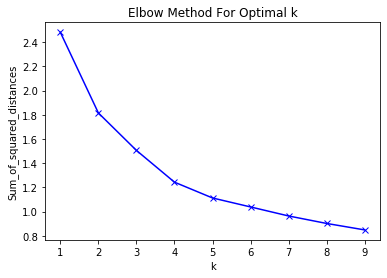

In [36]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Let's now perform the Cluster Analysis

In [37]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BCN_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 1, 0, 2, 1, 0, 1, 0, 1], dtype=int32)

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

BCN_merged = BCN_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
BCN_merged = BCN_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

BCN_merged.head() # check the last columns!

,District,Neighborhood,Population,Area (ha),Density,latitude,longitude,Italian restaurants,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciutat Vella,el Raval,47353,110.0,430,41.379518,2.168368,3,1,Bars and pubs,Spanish restaurants,Markets and food stores,Non-food stores,Arts and entertainment,Bakeries and coffee places,Latin American restaurants,Italian restaurants,Fast food restaurants,Non-classified places
1,Ciutat Vella,el Barri Gòtic,18629,81.6,228,41.383395,2.176912,6,1,Spanish restaurants,Markets and food stores,Bars and pubs,Hotels and accomodations,Non-food stores,Italian restaurants,Historic and public sites,Bakeries and coffee places,Arts and entertainment,Asian restaurants
2,Ciutat Vella,la Barceloneta,14857,109.5,136,41.380653,2.189927,3,1,Spanish restaurants,Bars and pubs,Markets and food stores,Historic and public sites,Bakeries and coffee places,Latin American restaurants,Fast food restaurants,Arts and entertainment,Non-food stores,Italian restaurants
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",22590,111.0,204,41.372251,2.177532,6,1,Spanish restaurants,Historic and public sites,Bars and pubs,Arts and entertainment,Hotels and accomodations,Italian restaurants,Gym and sports centers,Latin American restaurants,Markets and food stores,Bakeries and coffee places
4,Eixample,el Fort Pienc,32349,92.9,348,41.395925,2.182325,4,1,Bakeries and coffee places,Hotels and accomodations,Spanish restaurants,Bars and pubs,Gym and sports centers,Fast food restaurants,Historic and public sites,Non-food stores,Arts and entertainment,Asian restaurants


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BCN_merged['latitude'], BCN_merged['longitude'], BCN_merged['Neighborhood'], BCN_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Find Optimum Neighborhood

In [40]:
#Let's find which is the cluster with more Italian Restaurants
BCN_merged[['Cluster Labels','Italian restaurants']].groupby(['Cluster Labels']).sum()

,Italian restaurants
Cluster Labels,
0,54
1,207
2,0
3,23


In [41]:
#Let's analyse Cluster 1 which is the Cluster with more Italian Restaurants
Italian_Cluster=BCN_merged[BCN_merged['Cluster Labels']==1].reset_index(drop=True)
Italian_Cluster.head()

,District,Neighborhood,Population,Area (ha),Density,latitude,longitude,Italian restaurants,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciutat Vella,el Raval,47353,110.0,430,41.379518,2.168368,3,1,Bars and pubs,Spanish restaurants,Markets and food stores,Non-food stores,Arts and entertainment,Bakeries and coffee places,Latin American restaurants,Italian restaurants,Fast food restaurants,Non-classified places
1,Ciutat Vella,el Barri Gòtic,18629,81.6,228,41.383395,2.176912,6,1,Spanish restaurants,Markets and food stores,Bars and pubs,Hotels and accomodations,Non-food stores,Italian restaurants,Historic and public sites,Bakeries and coffee places,Arts and entertainment,Asian restaurants
2,Ciutat Vella,la Barceloneta,14857,109.5,136,41.380653,2.189927,3,1,Spanish restaurants,Bars and pubs,Markets and food stores,Historic and public sites,Bakeries and coffee places,Latin American restaurants,Fast food restaurants,Arts and entertainment,Non-food stores,Italian restaurants
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",22590,111.0,204,41.372251,2.177532,6,1,Spanish restaurants,Historic and public sites,Bars and pubs,Arts and entertainment,Hotels and accomodations,Italian restaurants,Gym and sports centers,Latin American restaurants,Markets and food stores,Bakeries and coffee places
4,Eixample,el Fort Pienc,32349,92.9,348,41.395925,2.182325,4,1,Bakeries and coffee places,Hotels and accomodations,Spanish restaurants,Bars and pubs,Gym and sports centers,Fast food restaurants,Historic and public sites,Non-food stores,Arts and entertainment,Asian restaurants


In [42]:
#Let's define Italian Restaurant Density
Italian_Cluster['Italian_density']=Italian_Cluster['Italian restaurants']/Italian_Cluster['Population']

In [43]:
#Let's now find which are the neighborhoods with lowest density of italian restaurants
Italian_Cluster.drop(['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'],axis=1, inplace=True)
#We'll drop neighborhoods with 0 italian restaurants as they do not suit for the analysis
Italian_Cluster=Italian_Cluster[Italian_Cluster['Italian restaurants'] != 0].reset_index(drop=True)
Italian_Cluster.sort_values(['Italian_density'],ascending=True).head()

,District,Neighborhood,Population,Area (ha),Density,latitude,longitude,Italian restaurants,Cluster Labels,Italian_density
6,Eixample,la Nova Esquerra de l'Eixample,58032,134.1,433,41.382816,2.149966,3,1,0.000052
0,Ciutat Vella,el Raval,47353,110.0,430,41.379518,2.168368,3,1,0.000063
19,Gràcia,la Vila de Gràcia,50102,132.1,379,41.403178,2.157166,4,1,0.000080
4,Eixample,el Fort Pienc,32349,92.9,348,41.395925,2.182325,4,1,0.000124
13,Les Corts,les Corts,46274,141.0,328,41.385244,2.132863,6,1,0.000130
